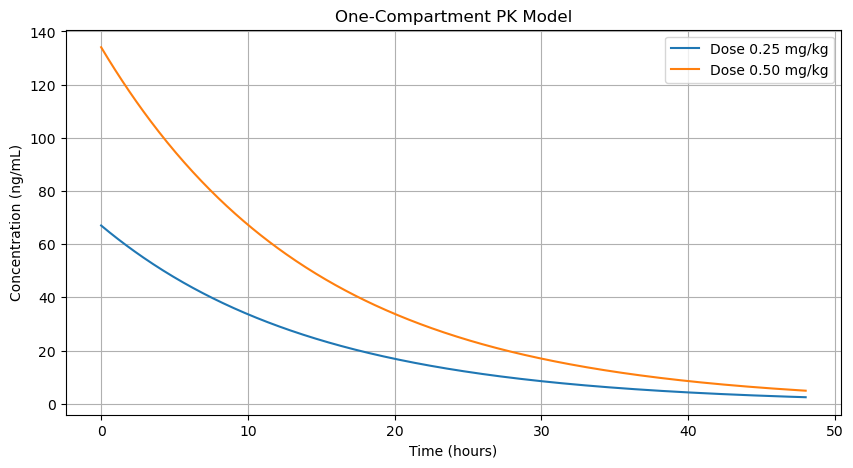

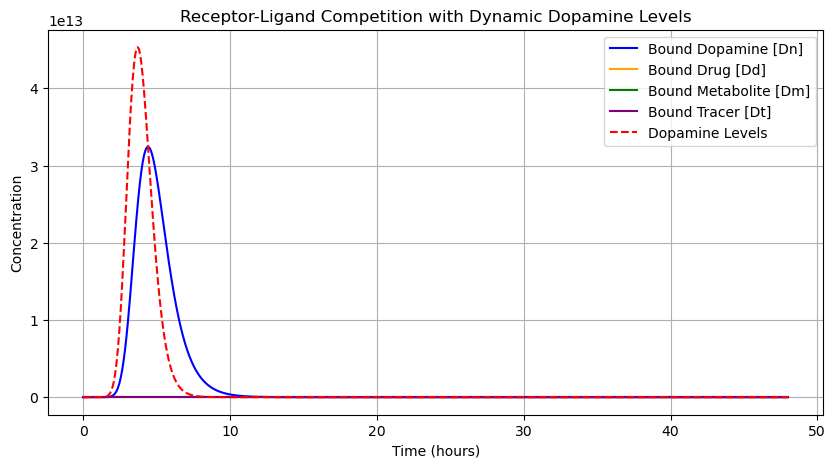

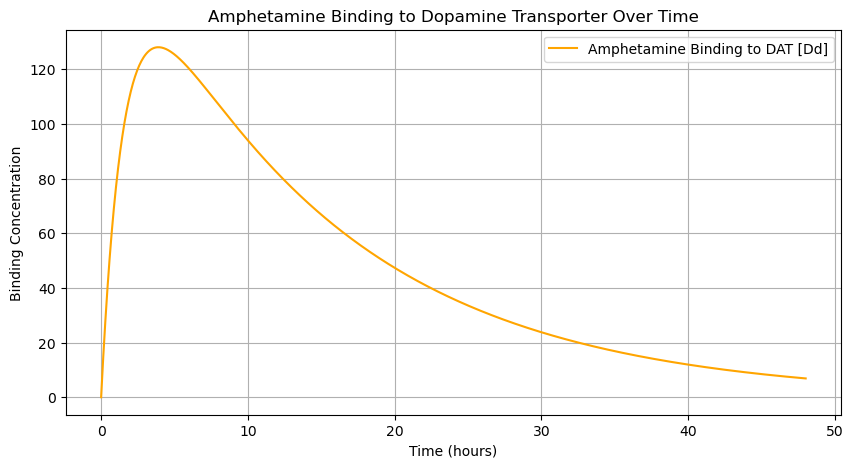

Max [Dn] (Bound dopamine): 32419404028491.76
Max [Dd] (Bound drug): 128.0535839774086
Max [Dm] (Bound metabolite): 0.0
Max [Dt] (Bound tracer): 0.0
Max [Dopamine levels]: 45320129482234.53


In [18]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# One-compartment pharmacokinetic (PK) model
def one_compartment_model(A, t, CL, V):
    dA_dt = -CL / V * A
    return dA_dt

# Parameters
BW = 70  # kg
CL_per_kg = 0.257  # L/h/kg
V_per_kg = 3.73  # L/kg
CL = CL_per_kg * BW * 1000  # mL/h
V = V_per_kg * BW * 1000  # mL

# Doses in ng
dose_025 = 0.25 * BW * 1e6
dose_050 = 0.5 * BW * 1e6
t_pk = np.linspace(0, 48, 500)

# Solve PK model for both doses
A_025 = odeint(one_compartment_model, dose_025, t_pk, args=(CL, V))
A_050 = odeint(one_compartment_model, dose_050, t_pk, args=(CL, V))
C_025 = A_025 / V
C_050 = A_050 / V

# DataFrames for plotting
df_025 = pd.DataFrame({'Time': t_pk, 'Concentration': C_025.flatten(), 'Dose': '0.25 mg/kg'})
df_050 = pd.DataFrame({'Time': t_pk, 'Concentration': C_050.flatten(), 'Dose': '0.50 mg/kg'})
combined_data = pd.concat([df_025, df_050])

# Plot PK results
plt.figure(figsize=(10, 5))
for dose, group in combined_data.groupby('Dose'):
    plt.plot(group['Time'], group['Concentration'], label=f'Dose {dose}')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (ng/mL)')
plt.title('One-Compartment PK Model')
plt.legend()
plt.grid()
plt.show()

# Dopamine decay function with drug effect
def dopamine_release(t, amphetamine_binding, base_release=1.0, amp_release_scale=1.5):
    return base_release * (1 + amp_release_scale * amphetamine_binding)

def dopamine_reuptake(dopamine_level, amphetamine_binding, base_reuptake=0.3, amp_inhib=0.8):
    return (base_reuptake * dopamine_level) * (1 - amp_inhib * amphetamine_binding)

# Receptor competition model with dynamic dopamine levels
def receptor_competition_with_amphetamine(y, t, K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met,
                                          K_on_tracer, K_d_tracer, Df, pk_conc, t_pk):
    Dn, Dd, Dm, Dt, dopamine_level = y
    drug_concentration = np.interp(t, t_pk, pk_conc)

    # Binding dynamics
    dDn_dt = K_on_dop * dopamine_level * Df - K_on_dop * K_d_dop * Dn
    dDd_dt = K_on_drug * drug_concentration * Df - K_on_drug * K_d_drug * Dd
    dDm_dt = K_on_met * 0 * Df - K_on_met * K_d_met * Dm
    dDt_dt = K_on_tracer * 0 * Df - K_on_tracer * K_d_tracer * Dt

    # Dopamine release and reuptake influenced by amphetamine binding
    dopamine_release_rate = dopamine_release(t, dDd_dt)  # Amphetamine binding boosts release
    dopamine_reuptake_rate = dopamine_reuptake(dopamine_level, dDd_dt)  # Binding inhibits reuptake
    dDopamine_dt = dopamine_release_rate - dopamine_reuptake_rate

    return [dDn_dt, dDd_dt, dDm_dt, dDt_dt, dDopamine_dt]

# Parameters and initial conditions
K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met, K_on_tracer, K_d_tracer = 1.0, 1.0, 0.8, 0.8, 0.6, 0.6, 0.4, 0.4
Df = 1.0
initial_conditions = [0.0, 0.0, 0.0, 0.0, 0.0]
t_rc = np.linspace(0, 48, 1000)
pk_concentrations = C_050.flatten()

# Solve receptor competition model
solution_with_amp = odeint(receptor_competition_with_amphetamine, initial_conditions, t_rc,
                           args=(K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met,
                                 K_on_tracer, K_d_tracer, Df, pk_concentrations, t_pk))

# Extract solutions
Dn, Dd, Dm, Dt, dopamine_levels = solution_with_amp.T

# Plot receptor competition results
plt.figure(figsize=(10, 5))
plt.plot(t_rc, Dn, label='Bound Dopamine [Dn]', color='blue')
plt.plot(t_rc, Dd, label='Bound Drug [Dd]', color='orange')
plt.plot(t_rc, Dm, label='Bound Metabolite [Dm]', color='green')
plt.plot(t_rc, Dt, label='Bound Tracer [Dt]', color='purple')
plt.plot(t_rc, dopamine_levels, label='Dopamine Levels', color='red', linestyle='dashed')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.title('Receptor-Ligand Competition with Dynamic Dopamine Levels')
plt.legend()
plt.grid()
plt.show()

# Additional plot: Amphetamine binding to dopamine transporter (Dd)
plt.figure(figsize=(10, 5))
plt.plot(t_rc, Dd, label='Amphetamine Binding to DAT [Dd]', color='orange')
plt.xlabel('Time (hours)')
plt.ylabel('Binding Concentration')
plt.title('Amphetamine Binding to Dopamine Transporter Over Time')
plt.legend()
plt.grid()
plt.show()

# Print max values for each variable
print(f"Max [Dn] (Bound dopamine): {np.max(Dn)}")
print(f"Max [Dd] (Bound drug): {np.max(Dd)}")
print(f"Max [Dm] (Bound metabolite): {np.max(Dm)}")
print(f"Max [Dt] (Bound tracer): {np.max(Dt)}")
print(f"Max [Dopamine levels]: {np.max(dopamine_levels)}")
